# PREPROCESSING

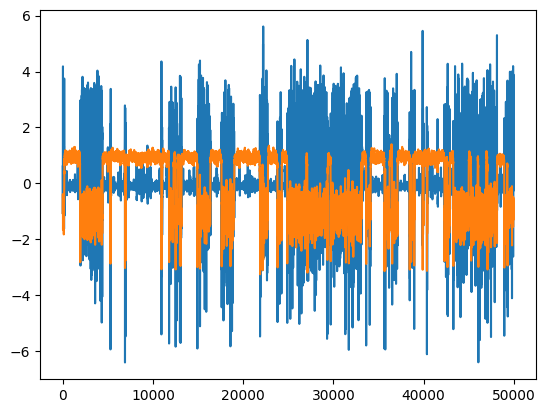

In [1]:
#OS Libraries
import os
import sys

#ML Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.serialization import SourceChangeWarning
from torch.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel

#Functionality Libraries
from tqdm import tqdm
from scipy.integrate import solve_ivp
import random
from scipy.stats import linregress
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import wandb
import datetime
import shutil
import seaborn as sns


psi = np.load(r'C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy')
psi = psi[:,1,:]
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi


# Pre-processing

lead = 1
trainN = 250_000
valN = 50_000
index = 63

# Defining the variable ranges
variable_range = [(0,24), (25, 49), (50, 74), (0, 49), (0,74)]

# Select the variable: 0 for real perturbation, 1 for imaginary perturbation, 2 for zonal winds
variable = 3
num_variables = variable_range[variable][1] - variable_range[variable][0] + 1

# Shuffle and map indices
np.random.seed(42)
valid_indices = np.arange(0, trainN - lead)
shuffled_indices = np.random.permutation(valid_indices)


# Now constrain the shuffled indices to the variable range
np_psi_train_input = psi[shuffled_indices, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_train_label = psi[shuffled_indices + lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label = torch.tensor(np_psi_train_label)

np_psi_val_input = psi[trainN:trainN+valN, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_val_label = psi[trainN+lead:trainN+valN+lead, :]
psi_val_input = torch.tensor(np_psi_val_input)
psi_val_label =  torch.tensor(np_psi_val_label)

plt.plot(np_psi_val_input[:,-1]) # Real and Imaginary PSI
plt.plot(np_psi_val_label[:,-1]) # Real and Imaginary PSI + Zonal Wind
plt.show()

In [2]:
# Define the encoder (MLP)
num_neurons = 1024
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(75, num_neurons)  
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, num_neurons)
        self.fc4 = nn.Linear(num_neurons, num_neurons)
        self.fc5 = nn.Linear(num_neurons, num_neurons)
        self.fc6 = nn.Linear(num_neurons, num_neurons)
        self.fc_mu = nn.Linear(num_neurons, latent_dim)
        self.fc_logvar = nn.Linear(num_neurons, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        x = torch.relu(self.fc5(x)) + x
        x = torch.relu(self.fc6(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, num_neurons)  
        self.fc2 = nn.Linear(num_neurons, num_neurons)  
        self.fc3 = nn.Linear(num_neurons, num_neurons)  
        self.fc4 = nn.Linear(num_neurons, num_neurons)  
        self.fc5 = nn.Linear(num_neurons, num_neurons)  
        self.fc6 = nn.Linear(num_neurons, num_neurons)  
        self.fc_output = nn.Linear(num_neurons, output_dim) 

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

output_dim = 75
condition_dim = num_variables


# CHOOSING BY EXP FIT

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)

def normalize_transition_time(slope_value, delta, transition_real):
    normalized = 1 - np.exp(-np.abs((slope_value - transition_real)) / delta)
    return normalized

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

# Code from Ira Shokar but slightly changed
def crps_score(predictions, actual):
    actual  = actual.unsqueeze(0)
    # First term: mean distance from observations to ensemble members
    mae     = torch.cdist(actual, predictions, 1).mean()
    # Second term: mean distance between ensemble members (properly normalized)
    ens_var = torch.cdist(predictions, predictions, 1).mean()
    
    return mae - 0.5 * ens_var

# Function to calculate transition durations
def calculate_transition_durations(y_values, upper_bound, lower_bound):

    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False
    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:  
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:  
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None  
            above_upper = True
            below_lower = False

        if below_lower and transition_start is None:
            transition_start = i
    return times_between_transitions

def KL_coefficient(real_data, pred_mean, delta, cycle, KL_by_dim_cycle):

    # Calculating KL divergence
    KL_real_data = real_data[:30000, 1, 63]
    KL_predictions = pred_mean[:30000]
    KL_row = []
    
    actual_hist, bin_edges = np.histogram(KL_real_data, bins=50, density=True)
    pred_hist, _ = np.histogram(pred_mean, bins=bin_edges, density=True)

    epsilon = 1e-10
    actual_hist += epsilon
    pred_hist += epsilon

    # Calculate KL divergence between the two histograms
    KL = np.sum(actual_hist * np.log(actual_hist / pred_hist))

    norm_KL = normalize_transition_time(KL, 1, 0)
    print(f"Normalized KL divergence for delta {delta}, cycle {cycle}: {norm_KL:.6f}")
    KL_by_dim_cycle[delta][cycle].append(norm_KL)

    return KL_real_data, KL_predictions, norm_KL

def Slope_fit(pred_durations, slope_real, epoch):
    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) > 0 and len(np.unique(pred_durations)) > 1:
        pred_data_sorted = np.sort(pred_durations)
        ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

        valid_indices_pred = ccdf_pred > 0
        x_fit_pred = pred_data_sorted[valid_indices_pred]
        y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

        slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)
        slope_diff_normalized = normalize_transition_time(slope_pred, 0.005, slope_real)
        return slope_diff_normalized

    else:
        print("No transitions detected in predictions for CCDF slope evaluation.")

def Mean_and_std_of_predictions(pred_durations, real_durations, delta, cycle, transitions_by_dim_cycle, transitions_normalized_by_dim_cycle, transitions_normalized_std_by_dim_cycle):
    transition_mean = np.mean(pred_durations)
    transition_std = np.std(pred_durations)

    transition_mean_diff = abs(transition_mean - np.mean(real_durations))
    transition_std_diff = abs(transition_std - np.std(real_durations))

    transition_mean_diff_normalized = normalize_transition_time(transition_mean_diff, 1000, np.mean(real_durations))
    transition_std_diff_normalized = normalize_transition_time(transition_std_diff, 1000, np.std(real_durations))

    if transition_std_diff_normalized == 0:
        transition_std_diff_normalized = 1

    transitions_by_dim_cycle[delta][cycle].append(transition_mean_diff)
    transitions_normalized_by_dim_cycle[delta][cycle].append(transition_mean_diff_normalized)
    transitions_normalized_std_by_dim_cycle[delta][cycle].append(transition_std_diff_normalized)

    return transition_mean_diff_normalized, transition_std_diff_normalized

# KL Annealing
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <=stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L


def model_restore(model_path, model):
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))

def inference(model, psi, mean_psi, std_psi, time_step, variable_range, variable, num_variables, latent_dim):
    start, end = variable_range[variable][0], variable_range[variable][1]+1
    initial_cond = torch.reshape(torch.tensor(psi[0,start:end]), [1, num_variables])
    z = torch.zeros([1,latent_dim])
    pred = np.zeros ([time_step, 75])

    for k in tqdm(range (0, time_step), desc="Inference"):

        with torch.inference_mode():
            model.eval()

            with autocast(device_type='cuda'):

                if (k ==0):

                    z = torch.randn_like(z).float().cuda(non_blocking=True)
                    initial_cond = initial_cond.float().cuda(non_blocking=True)

                    y = (model.decode(z,initial_cond)).detach().cpu().numpy()
                    pred[k,:] = y

                    y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                    initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

                else:
                    z = torch.randn_like(z).float().cuda(non_blocking=True)
                    initial_cond = torch.reshape(torch.tensor(pred[k-1,start:end]),[1,num_variables]).float().cuda(non_blocking=True)

                    y = (model.decode(z,initial_cond)).detach().cpu().numpy()
                    pred[k,:] = y

                    y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                    initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])
    
    return pred

def euclidean_distance_for_predictions(metrics):
    sum = 0
    for metric in metrics:
        sum += metric ** 2
    distance = np.sqrt(sum)
    return distance

def save_best_cycle_epoch(models, delta, cycle, epoch, 
                          exp_fit_normalized_by_dim_cycle, 
                          KL_by_dim_cycle, duration_diff_by_dim_cycle, 
                          best_models_saved, best_models, master_folder):
    
    best_model = None
    best_index = -1
    best_distance = float('inf')

    for i in range(len(models)):  # models contains each epoch's model in the current cycle

        metrics = [exp_fit_normalized_by_dim_cycle[delta][cycle][i],
                   KL_by_dim_cycle[delta][cycle][i], 
                   duration_diff_by_dim_cycle[delta][cycle][i]]
        
        distance = euclidean_distance_for_predictions(metrics)
        if distance < best_distance:
            best_distance = distance
            shutil.copyfile(models[i], f"{master_folder}/best_model_combined_distance_at_cycle_{cycle}_and_checkpoint_{epoch}.pth")
            print(f"New best model saved with distance {distance:.4f} at epoch {i+1}")
            best_index = i
            best_model = models[i]

    if best_index != -1:
        best_models_saved.append(best_model)
        best_models.append((cycle, best_index))

def save_best_epoch(best_models, best_models_saved, exp_fit_normalized_by_dim_cycle,
                    KL_by_dim_cycle, duration_diff_by_dim_cycle, delta, master_folder):
    
    print("Selecting the best model based on combined distance...")

    # Ensure best_models is not empty
    if not best_models:
        print("No best models found.")
        return
    
    # After all cycles - final best model selection
    best_model = None
    where_model = (-1, -1)
    best_model_distance = float('inf')

    print(f"Number of best models saved: {len(best_models)}")
    for idx, (cycle_num, epoch_idx) in enumerate(best_models):

        metrics = [exp_fit_normalized_by_dim_cycle[delta][cycle_num][epoch_idx], 
                   KL_by_dim_cycle[delta][cycle_num][epoch_idx], 
                   duration_diff_by_dim_cycle[delta][cycle_num][epoch_idx]]
        
        distance = euclidean_distance_for_predictions(metrics)        
        print(f"Distance for model from cycle {cycle_num+1}, epoch {epoch_idx+1}: {distance:.4f}")
        print(f"Current best distance: {best_model_distance:.4f}")
        
        if distance < best_model_distance:
            best_model_distance = distance
            best_model = best_models_saved[idx]
            where_model = (cycle_num, epoch_idx)

    # Save the best model  
    i,n = where_model
    cycle = i
    epoch = n

    if cycle == -1:
        print("No best model found.")
    else:
        shutil.copyfile(best_model, f"{master_folder}/best_model_combined_distance_with_cycle_{cycle+1}_and_epoch_{epoch+1}.pth")
        print(f"Best model saved with cycle {cycle+1} and epoch {epoch+1}.")




In [4]:

def Timeseries_plot(actual, pred, epoch, ax, folder):

    ax.plot(actual, 'b', label='Actual')
    ax.plot(pred, 'r', label='Predictions')

    ax.set_title(f"Timeseries | Epoch {epoch}", fontsize=16)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('Zonal Wind Value', fontsize=14)

    ax.legend(['Predictions', 'Actual'])
    ax.grid(True)


def PDF_plot(actual, pred, epoch, pdf_distance, ax, folder):

    sns.histplot(actual, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data', ax=ax)
    sns.histplot(pred, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions', ax=ax)

    ax.set_title(f"Probability Distribution Functions (PDFs) | Epoch {epoch} | KL Error: {pdf_distance:.4f}", fontsize=16)
    ax.set_xlabel('Zonal Wind (m/s)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    
    ax.axvline(np.mean(actual), color='black', linestyle='--', label=f'Real Mean: {np.mean(actual):.2f}')
    ax.axvline(np.mean(pred), color='red', linestyle='--', label=f'Pred Mean: {np.mean(pred):.2f}')

    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

def PDF_plot_inference(actual, pred, epoch, ax, folder):

    sns.histplot(actual, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data', ax=ax)
    sns.histplot(pred, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions', ax=ax)

    ax.set_title(f"Probability Distribution Functions (PDFs) | Epoch {epoch}", fontsize=16)
    ax.set_xlabel('Zonal Wind (m/s)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    
    ax.axvline(np.mean(actual), color='black', linestyle='--', label=f'Real Mean: {np.mean(actual):.2f}')
    ax.axvline(np.mean(pred), color='red', linestyle='--', label=f'Pred Mean: {np.mean(pred):.2f}')

    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

def Exp_fit_plot(folder, x_line_pred, y_values_pred, x_line_real, y_values_real, exponential_fit_pred, exponential_fit_real, epoch, exp_distance, range_distance, ax):

    ax.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)
    ax.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)

    ax.set_xlabel('Time Duration (Steps)')
    ax.set_ylabel('Exponential Fit')
    ax.set_title(f"Exponential Fits of Transition Return Periods | Epoch {epoch} | Exp Error: {exp_distance:.4f} | Range Error: {range_distance:.4f}", fontsize=16)
   
    ax.set_yscale("linear")  # y-axis log scale
    ax.set_xscale("linear")  # x-axis linear scale
    
    ax.grid()
    ax.legend()

def Final_avg_transition_plot(transitions_by_dim_cycle, transition_real, delta, num_cycles, folder):

    plt.figure(figsize=(10, 6))
    for c in range(num_cycles):
        plt.plot(transitions_by_dim_cycle[delta][c], 'o-', label=f'Cycle {c}')
    
    plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')

    plt.xlabel('Epoch within Cycle')
    plt.ylabel('Average Transition Value')
    plt.ylim(0.1,2000)
    plt.title(f'Average Transition Progress (Delta Coefficient={delta})')
    plt.grid(True)
    plt.legend()
    save_path = os.path.join(folder, "summary")
    save_path = os.path.join(save_path, f"transition_plot_all_cycles.png")
    plt.savefig(save_path)

    plt.show()

def Final_exp_fit_plot(exp_fit_by_dim_cycle, exponential_fit_real, delta, num_cycles, folder):
    
    plt.figure(figsize=(10, 6))
    for c in range(num_cycles):
        plt.plot(exp_fit_by_dim_cycle[delta][c], 'o-', label=f'Cycle {c}')
    
    plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')

    plt.xlabel('Epoch within Cycle')
    plt.ylabel('Exponential Fit Value')
    plt.title(f'Exponential Fit Progress (Delta Coefficient={delta})')
    plt.grid(True)
    plt.legend()

    save_path = os.path.join(folder, "summary")
    save_path = os.path.join(save_path, f"exponential_fit_plot_all_cycles.png")
    plt.savefig(save_path)
    
    plt.show()

def all_plot(actual, pred, x_line_pred, y_values_pred, x_line_real, y_values_real, 
             exponential_fit_pred, exponential_fit_real, pdf_distance, exp_distance, range_distance, epoch, folder):
    
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,1], height_ratios=[1,1])

    ax_timmeseries = fig.add_subplot(gs[:, 0])
    ax_pdf = fig.add_subplot(gs[0, 1])
    ax_exp_fit = fig.add_subplot(gs[1, 1])

    Timeseries_plot(actual, pred, epoch, ax_timmeseries, folder)
    PDF_plot(actual, pred, epoch, pdf_distance, ax_pdf, folder)
    Exp_fit_plot(folder, x_line_pred, y_values_pred, x_line_real, y_values_real, 
                 exponential_fit_pred, exponential_fit_real, epoch, exp_distance, range_distance, ax_exp_fit)
    
    distance = np.sqrt(pdf_distance**2 + exp_distance**2 + range_distance**2)
    fig.suptitle(f"Predictions vs Actual | Epoch {epoch} | Euclidean Metric Error: {distance}", fontsize=20)
    plt.subplots_adjust(wspace=0.2, hspace=0.35)  # Adjust these values as desired
    fig.tight_layout(pad=2.0)
    plt.savefig(os.path.join(folder, f"plots/all_plots_epoch_{epoch+1}.png"))
    plt.show()

def all_plot_inference(actual, pred, x_line_pred, y_values_pred, x_line_real, y_values_real, 
             exponential_fit_pred, exponential_fit_real, exp_distance, range_distance, epoch, folder):
    
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,1], height_ratios=[1,1])

    ax_timmeseries = fig.add_subplot(gs[:, 0])
    ax_pdf = fig.add_subplot(gs[0, 1])
    ax_exp_fit = fig.add_subplot(gs[1, 1])

    Timeseries_plot(actual, pred, epoch, ax_timmeseries, folder)
    PDF_plot_inference(actual, pred, epoch, ax_pdf, folder)
    Exp_fit_plot(folder, x_line_pred, y_values_pred, x_line_real, y_values_real, 
                 exponential_fit_pred, exponential_fit_real, epoch, exp_distance, range_distance, ax_exp_fit)
    
    fig.suptitle(f"Predictions vs Actual | Epoch {epoch}", fontsize=20)
    plt.subplots_adjust(wspace=0.2, hspace=0.35)  # Adjust these values as desired
    fig.tight_layout(pad=2.0)
    plt.savefig(os.path.join(folder, f"all_plots_epoch_{epoch+1}.png"))
    plt.show()

def Loss_plot(losses_training, losses_validation, cycle, delta, folder):

    plt.figure(figsize=(10,6))

    plt.plot(losses_training, label='Training Loss')
    plt.plot(losses_validation, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Losses for Cycle {cycle+1} with Delta {delta}')
    plt.legend()

    # save_path = os.path.join(folder, "summary")
    # save_path = os.path.join(save_path, f"loss_plot_cycle_{cycle+1}_delta_{delta}.png")
    # plt.savefig(save_path)
    
    plt.show()


In [5]:
beta_kl_coef = frange_cycle_linear(0.01, 0.3, 1_000, 1, 1)

# Training

In [39]:
torch.cuda.empty_cache()
# Initialization
scaler          = GradScaler()
latent_dim      = 32
kl_coefficients = [0.1]
kl_coef         = 0.5
delta_coefs     = [1]
time_step       = 300_000
num_cycles      = 1
ens_size        = 1
level           = 63
upper_bound     = 53.8 / 2.8935
lower_bound     = 7.41
learning_rate   = .0001
TRAIN_N         = 250_000
VAL_N           = 50_000
num_epochs      = 1_000
batch_size      = 1_024

run = wandb.init(entity="fabio2-the-university-of-chicago", project="ssw_research",
        config={
        "architecture": "VAE",
        "dataset": "Holton-Mass",
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "latent_dim size" : latent_dim,
        "KL list" : True,
        "kl_coef" : kl_coef,
        "ensemble size" : ens_size,
        "Beta KL Coefficients": beta_kl_coef,
        "Number of Neurons": num_neurons,
        },
)

run.define_metric("Epoch")
run.define_metric("*", step_metric="Epoch")

best_distance   = float('inf')

real_data = np.load(r'C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy')

real_data_1d    = real_data[:, 1, level]

# Function to calculate transition durations
real_durations      = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted    = np.sort(real_durations)
transition_real     = np.mean(real_data_sorted)

actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

# Compute CCDF slope for real data
ccdf_real           = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)
valid_indices_real  = ccdf_real > 0
x_fit_real          = real_data_sorted[valid_indices_real]
y_fit_real          = np.log(ccdf_real[valid_indices_real])
slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)
print(f"Reference Real Data CCDF Slope: {slope_real}")

# Compute exponential fit for real data
x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
exponential_fit_real = 1/np.mean(real_data_sorted)
y_values_real = exponential_fit_real*x_line_real

# Initialize dictionaries to store results
transitions_by_dim_cycle                = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
transitions_normalized_by_dim_cycle     = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
transitions_normalized_std_by_dim_cycle = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
duration_diff_by_dim_cycle              = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
slope_diff_by_dim_cycle                 = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
exp_fit_by_dim_cycle                    = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
exp_fit_normalized_by_dim_cycle         = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
KL_by_dim_cycle                         = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}

models_by_dim_cycle = []

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
master_folder = fr'save_folder/{timestamp}'
os.makedirs(master_folder)

for delta in delta_coefs:
    print(f"USING DELTA COEF OF {delta}")

    best_models         = []
    best_models_saved   = []

    losses_training     = []
    losses_validation   = []

    for cycle in range(0,num_cycles):

        models = []

        # Initialize the model, optimizer, and loss function
        model       = ConditionalVAE(latent_dim, output_dim, condition_dim)
        model       = model.cuda()
        optimizer   = optim.Adam(model.parameters(), lr=learning_rate)

        # Create the folder structure for saving results
        subfolders  = ['plots','checkpoints']
        for subfolder in subfolders:
            path = os.path.join(master_folder, subfolder)
            os.mkdir(path)
       
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(range (0, TRAIN_N, batch_size), desc=f"Training loop @ {epoch + 1}"):
                input_batch = psi_train_input[batch:batch + batch_size,:]
                label_batch = psi_train_label[batch:batch + batch_size,:]

                optimizer.zero_grad()

                with autocast(device_type='cuda'):
                    outputs, mus, logvars = zip(*[model(label_batch.float().cuda(non_blocking=True), input_batch.float().cuda(non_blocking=True)) for _ in range(ens_size)])
                    output = torch.stack(outputs)
                    mu = torch.stack(mus)
                    logvar = torch.stack(logvars)

                    reconstruction_loss = F.smooth_l1_loss(output, label_batch.float().cuda(non_blocking=True), reduction="mean")
                    crps_loss = crps_score(output, label_batch.float().cuda(non_blocking=True)) * 0.0001
                    kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum() * beta_kl_coef[epoch]

                    # Total loss
                    loss = reconstruction_loss + kl_loss + 0*crps_loss
                    
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                
            losses_training.append(loss.item())
            print(f'''Epoch {epoch+1}, 
                Reconstrunction Loss: {reconstruction_loss.item()}
                KL Loss: {kl_loss.item()}
                CRPS Loss: {crps_loss.item()}
                Total Loss: {loss.item()}
                ''')



            # Validation Loss
            for batch in tqdm(range (0, VAL_N, batch_size), desc=f"Validation loop @ {epoch + 1}"):

                model.eval()
                input_batch = psi_val_input[batch:batch + batch_size,:]
                label_batch = psi_val_label[batch:batch + batch_size,:]

                with torch.no_grad():
                    with autocast(device_type='cuda'):
                        outputs, mus, logvars = zip(*[model(label_batch.float().cuda(non_blocking=True), input_batch.float().cuda(non_blocking=True)) for _ in range(ens_size)])
                        output = torch.stack(outputs)
                        mu = torch.stack(mus)
                        logvar = torch.stack(logvars)

                        val_reconstruction_loss = F.smooth_l1_loss(output, label_batch.float().cuda(non_blocking=True), reduction="mean")
                        crps_loss = crps_score(output, label_batch.float().cuda(non_blocking=True)) * 0.0001
                        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum() * beta_kl_coef[epoch]  
                
                # Total loss
                val_loss = val_reconstruction_loss + kl_loss + 0*crps_loss

            losses_validation.append(val_loss.item())
            print(f'''
                Validation Reconstrunction Loss: {val_reconstruction_loss.item()}
                Validation KL Loss: {kl_loss.item()}
                Validation CRPS Loss: {crps_loss.item()}
                Validation Total Loss: {val_loss.item()}''')
 
            # Inference
            pred = inference(model, psi, mean_psi, std_psi, 
                             time_step, variable_range, variable, 
                             num_variables, latent_dim)
                
            # Denormalize final preds
            pred_mean = pred[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
            actual_values = psi[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
            predictions_1d = pred_mean[:, 63]  # shape (300000,)
           
            # Calculate transition durations for predictions
            pred_durations = calculate_transition_durations(predictions_1d, 
                                                            upper_bound, 
                                                            lower_bound)


            # Calculate KL coefficient
            KL_real_data, KL_predictions, avg_norm_KL = KL_coefficient(real_data, 
                                                                           predictions_1d, 
                                                                           delta, 
                                                                           cycle, 
                                                                           KL_by_dim_cycle)
            
            # Calculate mean and standard deviation of predictions
            transition_diff_normalized, transition_std_diff_normalized = Mean_and_std_of_predictions(pred_durations, 
                                                                                                     real_durations, 
                                                                                                     delta, cycle,
                                                                                                     transitions_by_dim_cycle,
                                                                                                     transitions_normalized_by_dim_cycle,
                                                                                                     transitions_normalized_std_by_dim_cycle)

            # Calculate the difference between exponential fits
            slope_diff_normalized = 1
            slope_diff_normalized = Slope_fit(pred_durations, slope_real, epoch)
            slope_diff_by_dim_cycle[delta][cycle].append(slope_diff_normalized)

            # Initialize variables for exponential fit and range of transitions
            exponential_fit_pred = 0
            duration_diff_normalized = 1

            if len(pred_durations) > 0 and  len(np.unique(pred_durations)) > 1:

                # Calculate the exponential fit for predictions
                x_line_pred = np.linspace(min(pred_durations), max(pred_durations), 100)
                exponential_fit_pred = 1/np.mean(pred_durations)
                exp_fit_by_dim_cycle[delta][cycle].append(exponential_fit_pred)
                exp_fit_normalized = normalize_transition_time(exponential_fit_pred, 0.005, exponential_fit_real)
                print(f"Exponential Fit Normalized: {exp_fit_normalized:.6f}")

                # Calculate the y-values for the exponential fit
                y_values_pred = exponential_fit_pred*x_line_pred

                # Calculate the range of transitions
                max_pred = np.max(pred_durations)
                min_pred = np.min(pred_durations)
                
                if max_pred > 0:

                    # Calculate the predicted range and normalize it
                    difference = abs(max_pred - min_pred)
                    duration_diff_normalized = normalize_transition_time(difference, 10000, abs(np.max(real_durations)-np.min(real_durations)))
                    duration_diff_by_dim_cycle[delta][cycle].append(duration_diff_normalized)
                    print(f"Duration Difference Normalized: {duration_diff_normalized:.6f}")
                    all_plot(actual_values[:30000, 63],
                                predictions_1d[:30000], 
                                x_line_pred, y_values_pred, 
                                x_line_real, y_values_real, 
                                exponential_fit_pred, exponential_fit_real, avg_norm_KL,
                                exp_fit_normalized, duration_diff_normalized,
                                epoch+1,master_folder)
                else:
                    print("No distribution of transitions detected in predictions.")
            else:
                exp_fit_by_dim_cycle[delta][cycle].append(exponential_fit_pred)
                duration_diff_by_dim_cycle[delta][cycle].append(duration_diff_normalized)
                exp_fit_normalized = normalize_transition_time(exponential_fit_pred, 0.005, exponential_fit_real)
                exp_fit_normalized_by_dim_cycle[delta][cycle].append(exp_fit_normalized)
                print("No transitions detected in predictions for exponential fit evaluation.")

            # Calculate accuracy by euclidean distance with specified metrics
            metrics = [exp_fit_normalized, avg_norm_KL, duration_diff_normalized]
            distance = euclidean_distance_for_predictions(metrics)
            print(f"Epoch {epoch+1}: Exponential Transition Fit Predictions Normalized: {exp_fit_normalized}, KL Normalized = {avg_norm_KL}, Duration Difference Normalized = {duration_diff_normalized}, Combined Distance = {distance:.6f}")
            
            # Save the model weights at each epoch
            path = f"{master_folder}/checkpoints/checkpoint_{epoch+1}"
            torch.save(model.state_dict(), path)
            print(f"Model weights saved to {master_folder} with point {epoch+1}.")
            models.append(path)

            log_dict = {
                "Epoch": epoch + 1,
                "Loss/train": reconstruction_loss,
                "Loss/val": val_reconstruction_loss,
                "KL/train": kl_loss,
                "KL/val": kl_loss,
                "CRPS/train": crps_loss,
                "Metrics/Exp Fit Normalized": exp_fit_normalized,
                "Metrics/Duration Diff Normalized": duration_diff_normalized,
                "Metrics/KL Normalized": avg_norm_KL,
                "Metrics/Beta KL Coefficient": beta_kl_coef[epoch],
            }
            print(f"Logging metrics for epoch {epoch+1}: {log_dict}")
            run.log(log_dict)

wandb: Currently logged in as: danieltonyh06 (fabio2-the-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

Model weights loaded from C:\Users\danie\OneDrive\Desktop\work_torch\checkpoint_11.


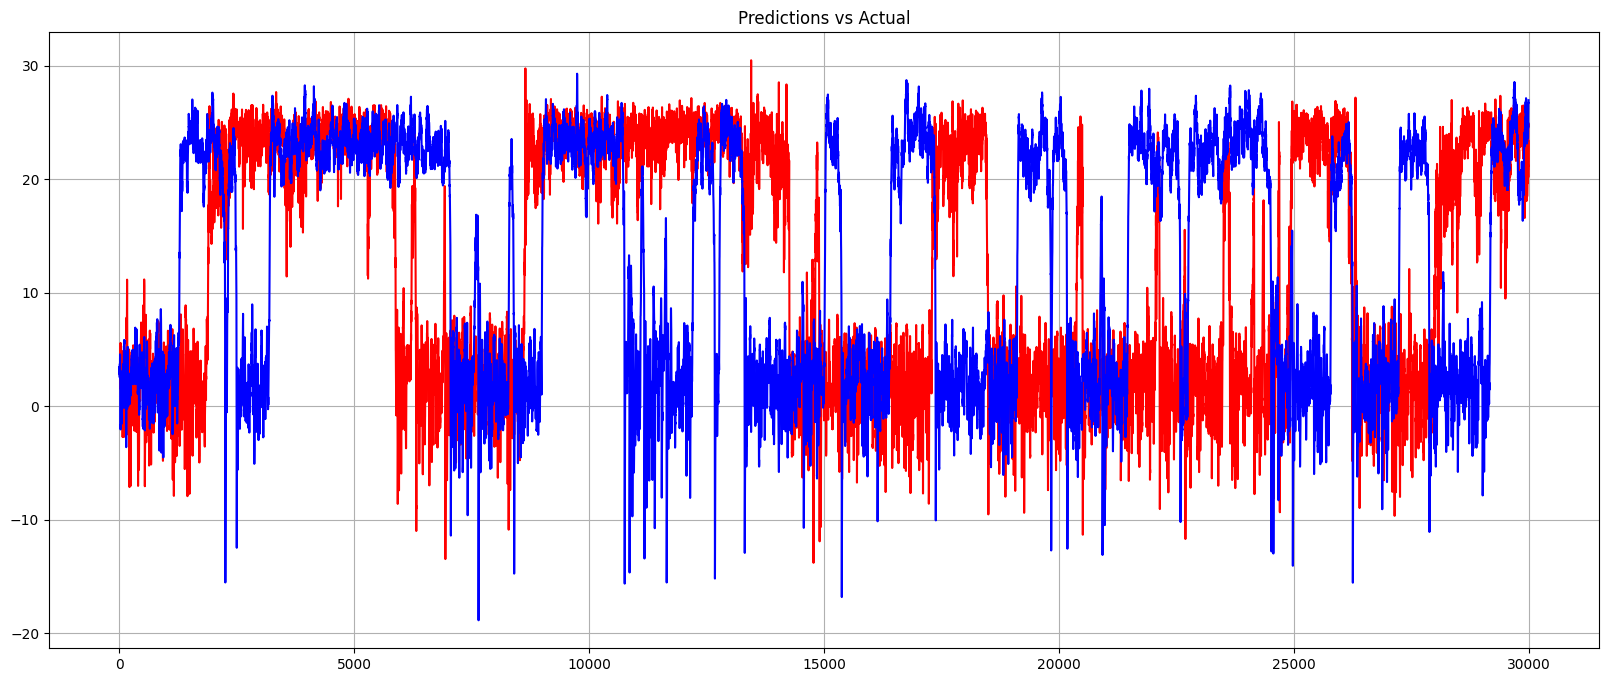

In [6]:
import datetime
import os

# Initialize the model, optimizer, and loss function
latent_dim = 32
output_dim = 75
condition_dim = num_variables
model = ConditionalVAE(latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
start, end = variable_range[variable][0], variable_range[variable][1]+1

# MODIFY THIS LINE FOR MODEL TESTING
past_model = True  # Set to True if you want to load past model weights
if past_model:
    model_weights_path = r"C:\Users\danie\OneDrive\Desktop\work_torch\checkpoint_11"
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))
        print(f"Model weights loaded from {model_weights_path}.")

for _ in range (0,1):

    start, end = variable_range[variable][0], variable_range[variable][1]+1
    initial_cond = torch.reshape(torch.tensor(psi[0,start:end]), [1, num_variables])
    time_step = 30_000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(non_blocking=True),initial_cond.float().cuda(non_blocking=True))).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(non_blocking=True),torch.reshape(torch.tensor(pred[k-1,start:end,select_ens]),[1,num_variables]).float().cuda(non_blocking=True))).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

    # Denormalize final preds
    pred = pred.reshape(pred.shape[0], pred.shape[1])
    pred_mean = pred[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
    
    # Denormalize test labels
    actual_values = psi[:time_step, :] * std_psi[:, :] + mean_psi[:, :]

    plt.figure(figsize=(20,8))
    plt.plot(pred_mean[0:time_step, 63],'r')
    plt.plot(actual_values[0:time_step, 63],'b')
    plt.grid(True)
    plt.title(f"Predictions vs Actual")

    

# INFERENCE

In [7]:
from sklearn.metrics import mean_squared_error

# Initialization
time_step = 30_000
real_data = np.load(r'C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy')
level = 63
upper_bound     = 53.8 / 2.8935
lower_bound     = 7.41
real_data_1d    = real_data[:, 1, level]

latent_dim = 32
output_dim = 75
condition_dim = num_variables
model = ConditionalVAE(latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
start, end = variable_range[variable][0], variable_range[variable][1]+1

model_weights_path = r'C:\Users\danie\OneDrive\Desktop\work_torch\checkpoint_11.pth'
past_model = True

if past_model:
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))

real_durations      = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted    = np.sort(real_durations)
transition_real     = np.mean(real_data_sorted)

actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

# Compute CCDF slope for real data
ccdf_real           = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)
valid_indices_real  = ccdf_real > 0
x_fit_real          = real_data_sorted[valid_indices_real]
y_fit_real          = np.log(ccdf_real[valid_indices_real])
slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)
print(f"Reference Real Data CCDF Slope: {slope_real}")

# Compute exponential fit for real data
x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
exponential_fit_real = 1/np.mean(real_data_sorted)
y_values_real = exponential_fit_real*x_line_real

pred = inference(model, psi, mean_psi, std_psi, 
                             time_step, variable_range, variable, 
                             num_variables, latent_dim)
# Denormalize final preds
pred_mean = pred[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
actual_values = psi[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
predictions_1d = pred_mean[:, 63]  # shape (300000,)

pred_durations = calculate_transition_durations(predictions_1d, 
                                                            upper_bound, 
                                                            lower_bound)


max_pred = np.max(pred_durations)
min_pred = np.min(pred_durations)
difference = abs(max_pred - min_pred)
duration_diff_normalized = normalize_transition_time(difference, 10000, abs(np.max(real_durations)-np.min(real_durations)))

x_line_pred = np.linspace(min(pred_durations), max(pred_durations), 100)
exponential_fit_pred = 1/np.mean(pred_durations)
exp_fit_normalized = normalize_transition_time(exponential_fit_pred, 0.005, exponential_fit_real)
y_values_pred = exponential_fit_pred*x_line_pred
epoch = 1_000_000
master_folder = r'C:\Users\danie\OneDrive\Desktop\work_torch'

all_plot_inference(actual_values[:30000, 63],
                                predictions_1d[:30000], 
                                x_line_pred, y_values_pred, 
                                x_line_real, y_values_real, 
                                exponential_fit_pred, exponential_fit_real,
                                exp_fit_normalized, duration_diff_normalized, epoch, master_folder
                                )


KeyboardInterrupt: 

# Single Time Step RMSE Analysis

In [8]:
import seaborn as sns

real_data = np.load(r'C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy')
valid_indices = np.random.choice(len(real_data) - 1, size=5_000, replace=False)            
rmses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shape = (len(valid_indices), 75)
single_step_predictions = np.zeros(shape, dtype=np.float32)
counter = 0

model.eval()
with torch.no_grad():
    for idx in tqdm(valid_indices, desc="Single Step Predictions"):
        # Prepare initial condition
        initial_cond = torch.tensor(psi[idx, start:end], dtype=torch.float32).unsqueeze(0).to(device)
        z = torch.randn((1, latent_dim), device=device)

        # Model prediction
        y = model.decode(z, initial_cond).cpu().numpy()

        # Denormalize prediction
        y_denorm = y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end]
        y_denorm_full = y * std_psi[:, :] + mean_psi[:, :]
        single_step_predictions[counter, :] = y_denorm_full

        # Denormalize true next step
        true_next = psi[idx + 1, :] * std_psi[:, :] + mean_psi[:, :]

        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(true_next, y_denorm_full))
        rmses.append(rmse)
        counter += 1


# Compute feature 63 values (denormalized)
print(single_step_predictions.shape)
feature_63_vals = np.array([real_data[i, 0, 63] for i in valid_indices])
predicted_63_vals = single_step_predictions[:, 63]
rmses = np.array(rmses)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(18, 32))

#histograms
sns.histplot(feature_63_vals, kde=True, bins=50, alpha=0.8, element='step', 
             label='Real Data', color='blue', ax=ax1)
sns.histplot(predicted_63_vals, kde=True, bins=50, alpha=0.7, element='step', 
             label='Predictions', color='red', ax=ax1)
ax1.legend()
ax1.set_xlabel("Feature 63 (U @x` 30km)")
ax1.set_ylabel("Frequency")
ax1.set_title("Feature 63 (U @ 30km)")
ax1.grid(True, linestyle='--', alpha=0.5)
 
bin_edges = np.linspace(feature_63_vals.min(), feature_63_vals.max(), 50)
bin_indices = np.digitize(feature_63_vals, bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
mean_rmses = [rmses[bin_indices == i].mean() for i in range(1, len(bin_edges))]

ax3.bar(bin_centers, mean_rmses, width=np.diff(bin_edges), 
        edgecolor='k', alpha=0.7, align='center')
ax3.set_xlabel("Feature 63 (U @ 30km)")
ax3.set_ylabel("Mean 1-step RMSE")
ax3.set_title("Mean RMSE per Feature 63 Bin")
ax3.grid(True)

ax2.scatter(feature_63_vals, rmses, color='red', alpha=0.4, s=10)
ax2.set_xlabel("Feature 63 (U @ 30km)")
ax2.set_ylabel("1-step RMSE")
ax2.set_title("RMSE vs Initial Feature 63 Value")
ax2.grid(True)

hb = ax4.hexbin(feature_63_vals, rmses, gridsize=30, cmap='inferno', bins = 'log')
ax4.set_xlabel("Feature 63 (U @ 30km)")
ax4.set_ylabel("1-step RMSE")
ax4.set_title("RMSE vs Initial Feature 63 Value (Density)")
fig.colorbar(hb, ax=ax4, label='log10(count)')
ax4.grid(True)
plt.tight_layout()
plt.show()

Single Step Predictions:   0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'start' is not defined

# Principal Component Analysis

Mu shpae:  torch.Size([756, 32])
==>> pca: PCA(n_components=3)
==>> latent_3d: (756, 3)
Explained variance by PC1: 0.8849
Explained variance by PC2: 0.0601
Explained variance by PC3: 0.0231
Total explained variance (PC1+2+3): 0.9680


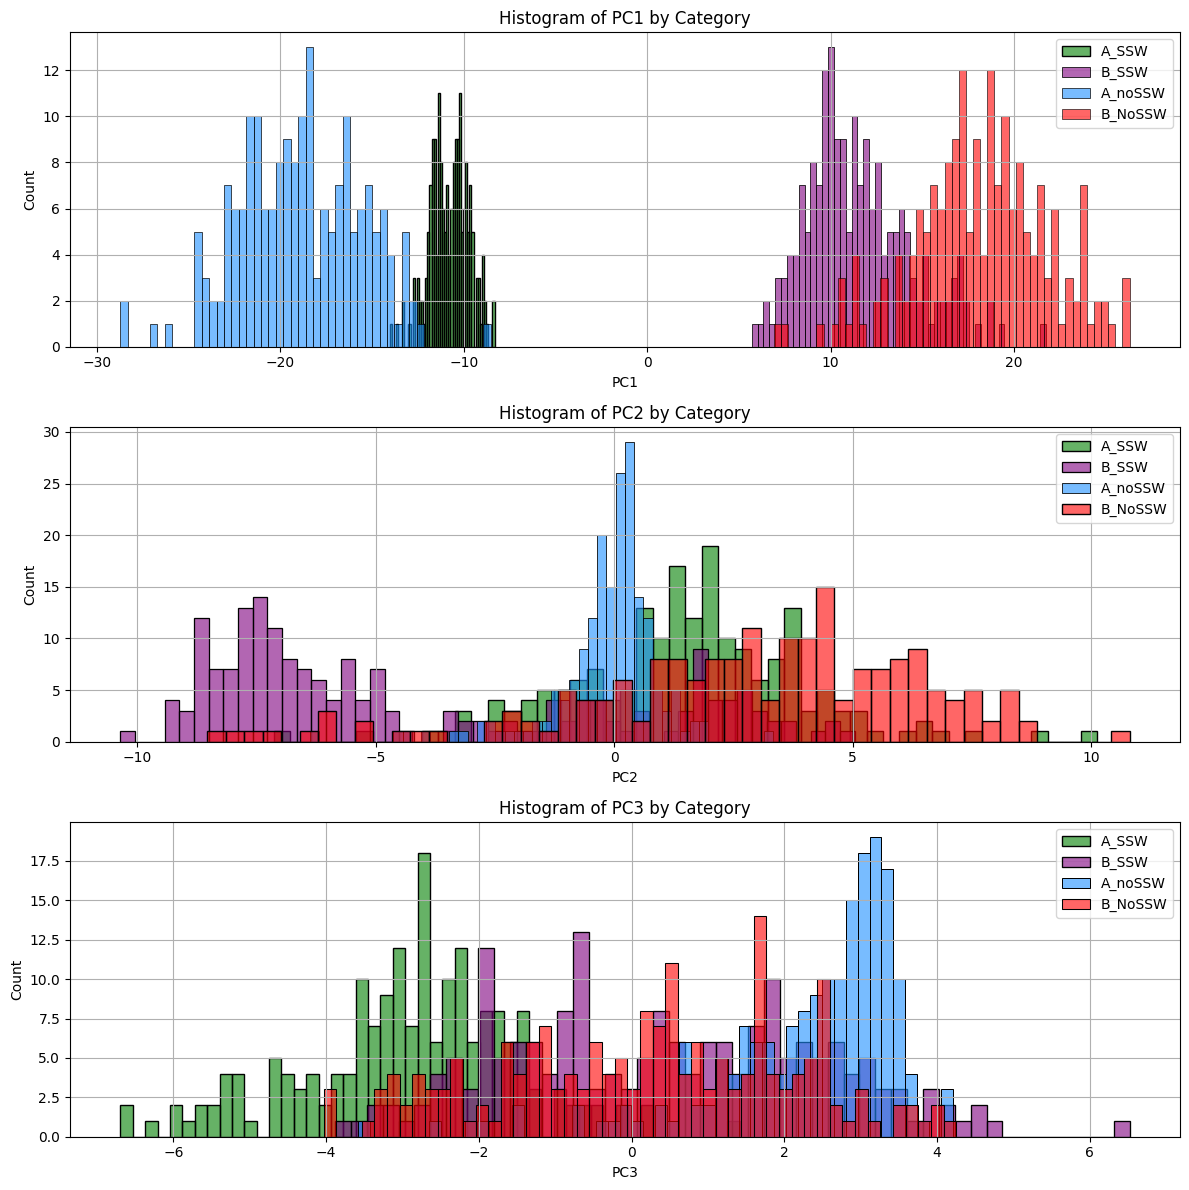

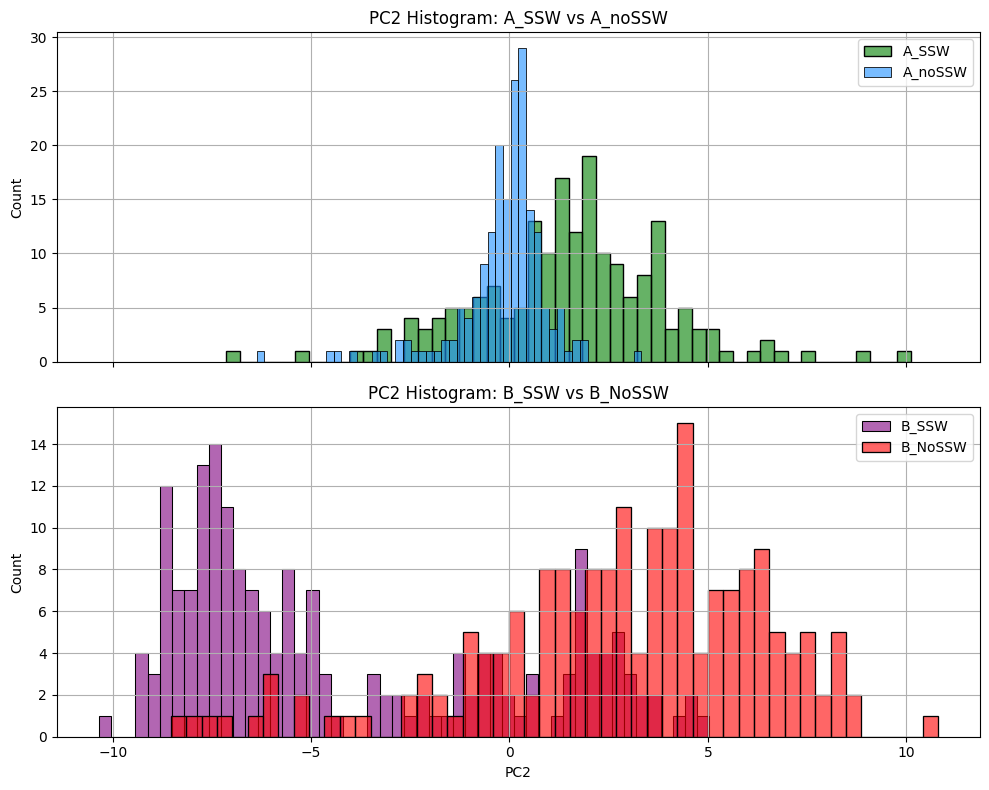

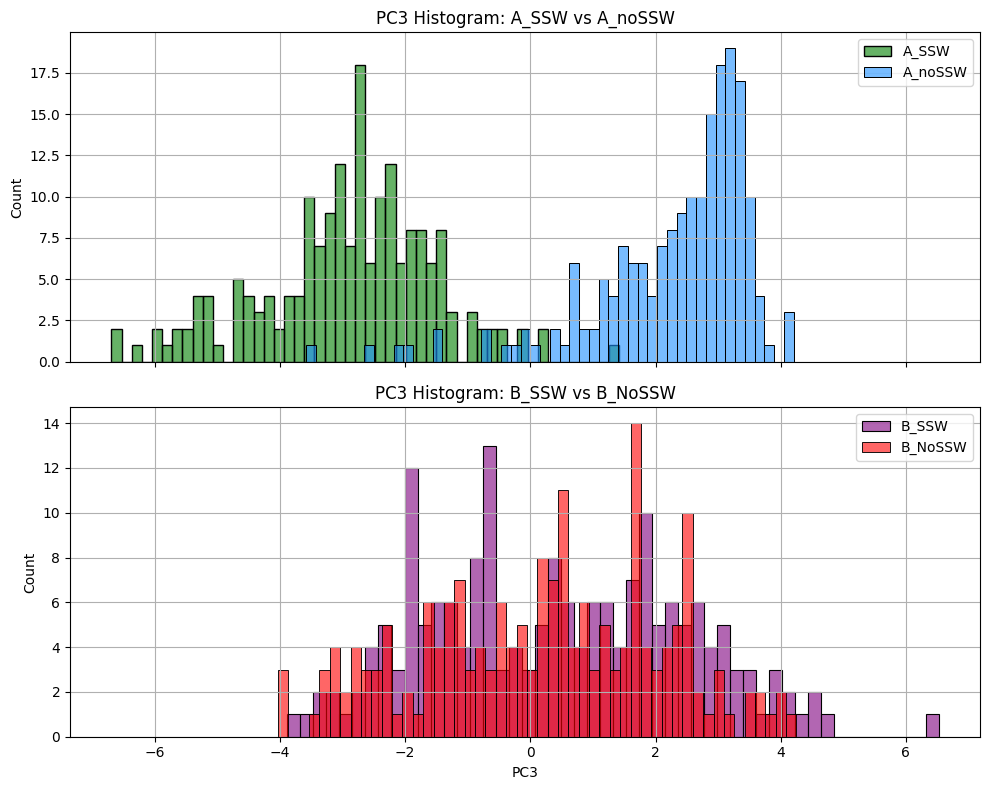

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd
import seaborn as sns

# Load data
data = np.load("long_run_310k.npy")
zonal_wind = data[:, 0, 63]
upper, lower = 53.8 / 2.8935, 7.41

def detect_transitions_A_to_B(u_series, upper, lower):
    transitions = []
    i = 1
    while i < len(u_series) - 1:
        if u_series[i - 1] > upper and u_series[i] <= upper:  # exited A
            j = i + 1
            while j < len(u_series) and u_series[j] <= upper:
                if u_series[j] < lower:  # entered B
                    transitions.append(i)
                    break
                j += 1
            i = j
        else:
            i += 1
    return np.array(transitions)


def detect_transitions_B_to_A(u_series, upper, lower):
    transitions = []
    i = 1
    while i < len(u_series) - 1:
        if u_series[i - 1] < lower and u_series[i] >= lower:  # exited B
            j = i + 1
            while j < len(u_series) and u_series[j] >= lower:
                if u_series[j] > upper:  # entered A
                    transitions.append(i)
                    break
                j += 1
            i = j
        else:
            i += 1
    return np.array(transitions)


ssw_indices_A = detect_transitions_A_to_B(zonal_wind, upper, lower)
ssw_indices_B = detect_transitions_B_to_A(zonal_wind, upper, lower)

transition_indices = np.union1d(ssw_indices_A, ssw_indices_B)
total_len = len(data)
non_ssw_sample_A = np.where((zonal_wind > upper) & (~np.isin(np.arange(total_len), transition_indices)))[0]

non_ssw_sample_B = np.where((zonal_wind < lower) & (~np.isin(np.arange(total_len), transition_indices)))[0]

n_samples = min(len(ssw_indices_A), len(non_ssw_sample_A), len(non_ssw_sample_B))
rng = np.random.default_rng(2026)
#302713
non_ssw_sample_A = rng.choice(non_ssw_sample_A, size=n_samples, replace=False)
non_ssw_sample_B = rng.choice(non_ssw_sample_B, size=n_samples, replace=False)

X = np.vstack([
    data[ssw_indices_A, 0],
    data[ssw_indices_B, 0],
    data[non_ssw_sample_A, 0],
    data[non_ssw_sample_B, 0]
]).astype(np.float32)

labels = (
    ["A_SSW"] * len(ssw_indices_A) +
    ["B_SSW"] * len(ssw_indices_B) +
    ["A_noSSW"] * len(ssw_indices_A) +
    ["B_NoSSW"] * len(ssw_indices_B)
)


model.eval()
# Encode data
with torch.no_grad():
    mu , _ = model.encode(torch.tensor(X, dtype=torch.float32).cuda())
    mu_np = mu.cpu().numpy()

print("Mu shpae: " , mu.shape)

# PCA
pca = PCA(n_components=3)
print(f"==>> pca: {pca}")

latent_3d = pca.fit_transform(mu_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")

print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d, columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, mu",
                     width=1200, height=800)
fig.show()


fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

components = ["PC1", "PC2", "PC3"]
colors = {
    "A_SSW": "green",
    "B_SSW": "purple",
    "A_noSSW": "dodgerblue",
    "B_NoSSW": "red"
}

for i, comp in enumerate(components):
    ax = axes[i]
    for label in df["Category"].unique():
        sns.histplot(
            df[df["Category"] == label][comp],
            bins=50,
            color=colors[label],
            alpha=0.6,
            label=label,
            ax=ax,
            kde=False
        )
    ax.set_title(f"Histogram of {comp} by Category")
    ax.set_xlabel(comp)
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- PC2 Histogram: A group (A_SSW and A_noSSW) ---
for label in ["A_SSW", "A_noSSW"]:
    subset = df[df["Category"] == label]["PC2"]
    if not subset.empty:
        sns.histplot(subset, bins=50, color=colors[label], alpha=0.6, label=label, ax=axes[0], kde=False)

axes[0].set_title("PC2 Histogram: A_SSW vs A_noSSW")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].grid(True)

# --- PC2 Histogram: B group (B_SSW and B_NoSSW) ---
for label in ["B_SSW", "B_NoSSW"]:
    subset = df[df["Category"] == label]["PC2"]
    if not subset.empty:
        sns.histplot(subset, bins=50, color=colors[label], alpha=0.6, label=label, ax=axes[1], kde=False)

axes[1].set_title("PC2 Histogram: B_SSW vs B_NoSSW")
axes[1].set_xlabel("PC2")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- PC3 Histogram: A group (A_SSW and A_noSSW) ---
for label in ["A_SSW", "A_noSSW"]:
    subset = df[df["Category"] == label]["PC3"]
    if not subset.empty:
        sns.histplot(subset, bins=50, color=colors[label], alpha=0.6, label=label, ax=axes[0], kde=False)

axes[0].set_title("PC3 Histogram: A_SSW vs A_noSSW")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].grid(True)

# --- PC3 Histogram: B group (B_SSW and B_NoSSW) ---
for label in ["B_SSW", "B_NoSSW"]:
    subset = df[df["Category"] == label]["PC3"]
    if not subset.empty:
        sns.histplot(subset, bins=50, color=colors[label], alpha=0.6, label=label, ax=axes[1], kde=False)

axes[1].set_title("PC3 Histogram: B_SSW vs B_NoSSW")
axes[1].set_xlabel("PC3")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Latent Space Conditioning

==>> data[ssw_indices_A, 0, 63]: [18.20437291 17.99835456 17.89335855 18.27943322 17.87582797 18.21721643
 18.22396196 18.37825371 18.55779484 18.47323164 18.52256468 18.24167076
 18.05116269 17.16246204 17.95081513 18.185244   17.3431973  18.53211441
 18.49160196 18.479084   18.34645486 17.42100972 18.37494595 17.38797552
 18.5467369  18.54599528 17.79441939 18.5398223  18.42172158 18.29324936
 18.34828982 18.28066428 18.24471797 17.91934106 17.98836681 18.36061133
 18.20658074 17.94634386 18.19976481 18.44565034 18.17920063 18.07858284
 17.88920353 18.27191294 18.53502617 17.68279998 18.48172211 18.52574565
 18.39096416 18.18503731 18.13682457 18.46678426 18.21126535 18.38160981
 17.55460658 18.52448847 18.37093894 17.3657671  18.52320965 17.83510674
 18.47939334 18.10762904 18.09710374 18.25318741 18.21361557 18.44965067
 18.24548747 18.56193533 18.36580889 18.4362309  18.12284348 18.48345833
 17.72957766 18.57719993 18.58049001 18.35994584 17.68813253 18.30747848
 18.44089337 18.39

Trajectory 1: 100%|██████████| 500/500 [00:00<00:00, 697.89it/s]


==>> transition_fraction: 0.000


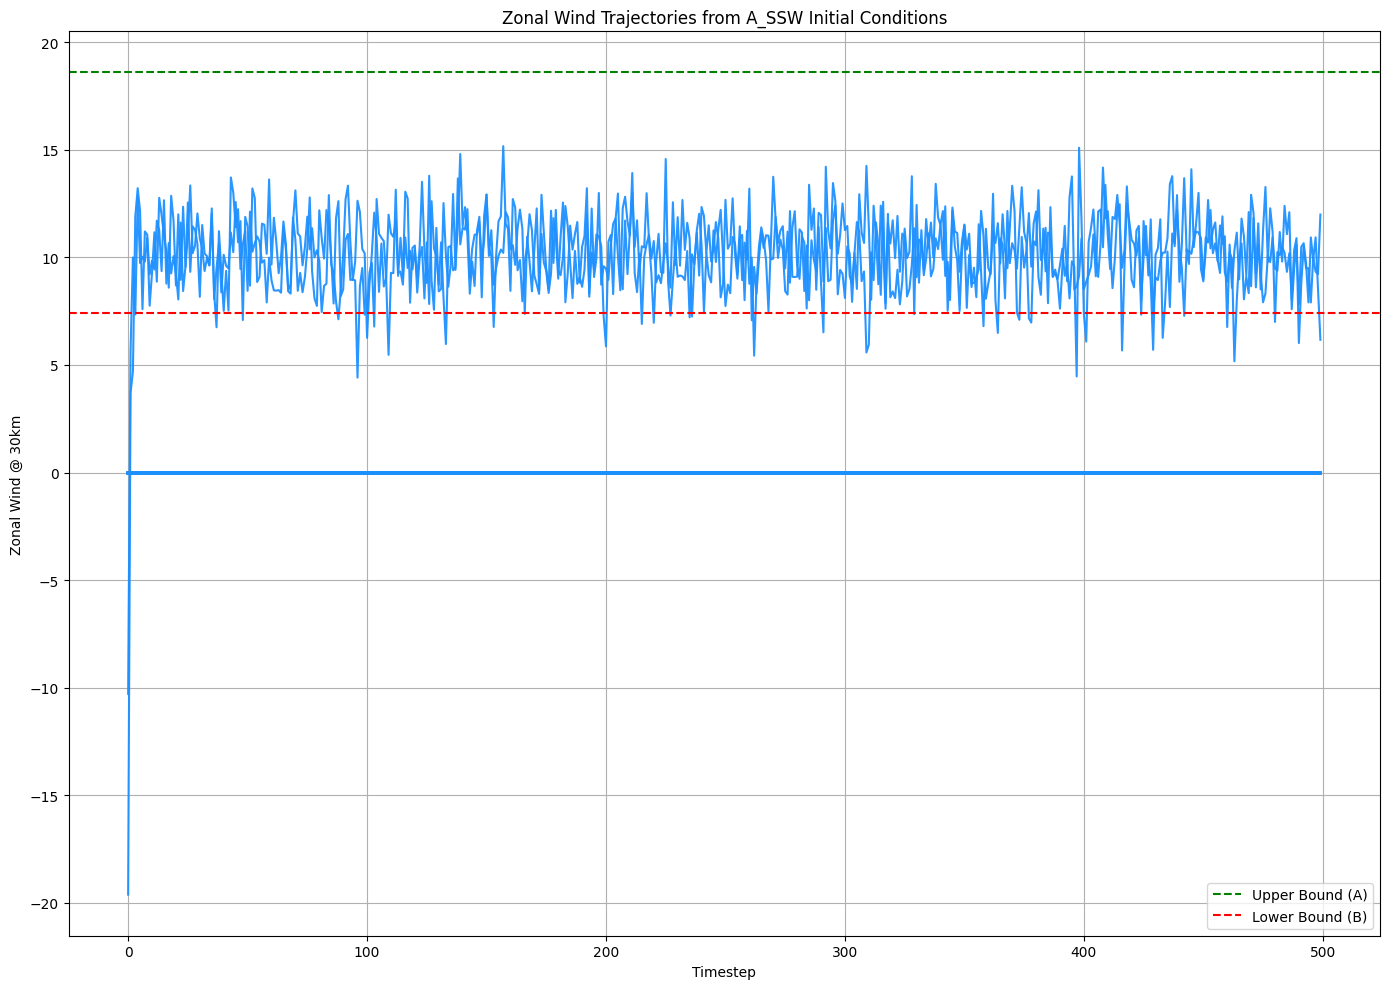

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.cuda.amp import autocast

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A_transition_initial_conditions = data[ssw_indices_A, 0]
print(f"==>> data[ssw_indices_A, 0, 63]: {data[ssw_indices_A, 0, 63]}")
print(f"==>> ssw_indices_A length: {len(ssw_indices_A)}")

timesteps = range(500)
timestep = len(timesteps)
shape = (len(ssw_indices_A), timestep, 75)
ATIC_ensemble_of_preds = np.zeros(shape, dtype=np.float32)

start, end = variable_range[variable][0], variable_range[variable][1] + 1
upper_bound = 53.8 / 2.8935
lower_bound = 7.41

# --- Inference ---
model.eval()
for ICIndex in range(len(ssw_indices_A)-187):
    initial_vec = A_transition_initial_conditions[ICIndex, start:end]
    initial_cond = torch.tensor(initial_vec, dtype=torch.float32).reshape(1, -1).to(device)
    z = torch.zeros((1, latent_dim), device=device)

    with torch.no_grad(), torch.inference_mode():
        for k in tqdm(timesteps, desc=f"Trajectory {ICIndex}"):
            z = torch.randn_like(z).float().cuda(non_blocking=True)
            initial_cond = initial_cond.float().cuda(non_blocking=True)

            # Predict
            y = model.decode(z, initial_cond).detach().cpu().numpy()

            # Denormalize full prediction
            y_denorm_full = y * std_psi + mean_psi
            ATIC_ensemble_of_preds[ICIndex, k, :] = y_denorm_full[0]

            # Prepare next input
            y_contracted = y_denorm_full[:, start:end]
            y_norm = (y_contracted - mean_psi[:, start:end]) / std_psi[:, start:end]
            initial_cond = torch.tensor(y_norm, dtype=torch.float32).to(device)

# --- Transition Detection ---
def detect_A_to_B_transition(series, upper, lower):
    if series[0] <= upper:
        return False
    for i in range(1, len(series)):
        if series[i] > upper:
            return False
        if series[i] < lower:
            return True
    return False

zonal_wind_preds = ATIC_ensemble_of_preds[:, :, 63]  # index 63 = 30km zonal wind
transition_flags = np.array([detect_A_to_B_transition(traj, upper_bound, lower_bound)
                             for traj in zonal_wind_preds])
transition_fraction = np.mean(transition_flags)
print(f"==>> transition_fraction: {transition_fraction:.3f}")

# --- Plotting ---
plt.figure(figsize=(14, 10))
for traj in zonal_wind_preds:
    plt.plot(traj, color='dodgerblue', alpha=0.95)
plt.axhline(upper_bound, color='green', linestyle='--', label='Upper Bound (A)')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound (B)')
plt.title("Zonal Wind Trajectories from A_SSW Initial Conditions")
plt.xlabel("Timestep")
plt.ylabel("Zonal Wind @ 30km")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Results Table ---
result_df = pd.DataFrame({
    "Total Samples": [len(ssw_indices_A)],
    "Transitions Detected": [np.sum(transition_flags)],
    "Fraction Transitioned": [transition_fraction]
})



#switch out the latent space for the characteristic A_ssw space and repeat. observe the fraction of times they transition

#switch out the the characteristic A_nossw space and repeat. hopefully observe no transitions

#repeat tall the previous steps for A_nossw initial conditions

#repeat all previous for steps for state B



# Attempting to Visualize the State Space of the Model

In [23]:
import numpy as np
import torch
import plotly.express as px
import pandas as pd
model.eval()

# Feature indices to visualize
feature_indices = [14, 38, 64]
num_examples = 25

records = []

index = 45_343
for t in range(num_examples):
    initial_cond_raw = psi[index, :]
    true_next_state = psi[index + 1, :]
    index += 1

    # Normalize initial condition
    initial_cond_norm = (initial_cond_raw - mean_psi[:, 0]) / std_psi[:, 0]
    initial_cond_norm = initial_cond_norm[:50]
    initial_cond_tensor = torch.tensor(initial_cond_norm, dtype=torch.float32, device=device).view(1, -1)

    # Predict next state
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        pred_norm = model.decode(z, initial_cond_tensor)
        pred_norm = pred_norm.squeeze().cpu().numpy()
        pred_denorm = pred_norm * std_psi[:, 0] + mean_psi[:, 0]

    #denormalize the ground truth
    true_next_denorm = true_next_state * std_psi[:, 0] + mean_psi[:, 0]
    initial_cond_denorm = initial_cond_raw

    #Extract feature triplets
    ic_feats = initial_cond_denorm[feature_indices]
    pred_feats = pred_denorm[feature_indices]
    true_feats = true_next_denorm[feature_indices]

    # Add to records
    records.append({"Trajectory": f"Traj {t}", "label": "Initial Condition", "x": ic_feats[0], "y": ic_feats[1], "z": ic_feats[2]})
    records.append({"Trajectory": f"Traj {t}", "label": "Prediction", "x": pred_feats[0], "y": pred_feats[1], "z": pred_feats[2]})
    records.append({"Trajectory": f"Traj {t}", "label": "Ground Truth", "x": true_feats[0], "y": true_feats[1], "z": true_feats[2]})

# DataFrame for plotting
df = pd.DataFrame(records)

# Plot with Plotly
fig = px.scatter_3d(
    df, x="x", y="y", z="z", color="label", symbol="label",
    title="Initial → Prediction vs Ground Truth (3D Feature Space)",
    width=1400, height=600
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(
    xaxis_title=f"Feature {feature_indices[0]}",
    yaxis_title=f"Feature {feature_indices[1]}",
    zaxis_title=f"Feature {feature_indices[2]}"
))
fig.show()